# Basic seq2seq model
    - Use attention builded model.
    - Input vector of probs of each digit: Output of a lenet model.
    - try to identify the original sequence encoded by embedings.

In [1]:
from __future__ import print_function

import tensorflow as tf
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10) 
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap


In [2]:
# Define lis of chars and translation dictionaries

seq_length = 5

PAD_ID = 10
GO_ID = 11
EOL_ID = 12
char_list = '0123456789'

encode_dict={}
decode_dict={}
for i, s in enumerate(char_list):
    encode_dict[s]=i
    decode_dict[i]=s

decode_dict[10]='-PAD'
decode_dict[11]='GO'
decode_dict[12]='-EOL'

print(encode_dict)
print(decode_dict)



{'1': 1, '0': 0, '3': 3, '2': 2, '5': 5, '4': 4, '7': 7, '6': 6, '9': 9, '8': 8}
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '-PAD', 11: 'GO', 12: '-EOL'}


In [3]:
#Read MNIST data

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp", one_hot=True)

print(mnist.train.images.shape)
print(mnist.test.images.shape)
print(mnist.train.labels.shape)
print(mnist.test.labels.shape)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/t10k-labels-idx1-ubyte.gz
(55000, 784)
(10000, 784)
(55000, 10)
(10000, 10)


In [4]:
#Sequences generator
def seq_generator(X=mnist.train.images, y=mnist.train.labels, batch_size=256, size_word=10, size=10, x_slides=10):    
    '''
    Generate a batch of character sequence of images with 1 to size digits of nmist
    Return arrays with images in fixed size, words in fixed lenth and lengths of words
    '''
    X = np.reshape(X,[-1,28,28])
    w = X.shape[2]
    for i in range(200):
        X_batch = np.zeros([batch_size,X.shape[1],X.shape[2]*size])
        X_batch_seg = []
        X_length = np.zeros([batch_size], dtype=np.uint16)
        #enc_inp = np.zeros([batch_size, l], dtype=np.uint16)
        dec_inp = np.zeros([batch_size, size+1, 13], dtype=np.float32)
        weigth = np.zeros([batch_size, size+1], dtype=np.float32)
        target = np.zeros([batch_size, size+1], dtype=np.uint16)
        
        for batch in range(batch_size):
            l_word = random.randint(1,size_word)
            X_length[batch] = int((float(l_word)/float(size)) * (x_slides+1))
            digits_randomized = [int(rand) for rand in np.random.random_sample(l_word) * X.shape[0]]
            #Initialize dec_inp with GO at begining
            dec_inp[batch,0, GO_ID] = 1
            #Initialize taget wit PAD
            target[batch,:] = PAD_ID
            weigth[batch,0] = 1.
            for n, digit in enumerate(digits_randomized):
                #Extract batch data
                X_batch[batch, :, n*w:(n+1)*w] = X[digit]
                dec_inp[batch, n+1, encode_dict[str(np.argmax(y[digit]))]] = 1
                weigth[batch, n+1] = 1.
                target[batch, n] = encode_dict[str(np.argmax(y[digit]))]
            target[batch,n+1] = EOL_ID
            #Complete dec_inp with PAD
            for n2 in range(n+2, size+1):
                dec_inp[batch, n2, PAD_ID] = 1 
                
            #Segment X with a sliding window
            step = (X.shape[2]*(size-1)) / x_slides
            X_batch_seg_batch = []
            for i_xb in range(0, X.shape[2]*(size-1), step):
                X_batch_seg_batch += [X_batch[batch, :, i_xb:i_xb+w]]
            X_batch_seg += [X_batch_seg_batch]
        X_batch_seg = np.transpose(X_batch_seg, axes=[0,2,3,1])
               
            
        yield np.array(X_batch_seg), X_length, dec_inp, weigth, target
        

seq = seq_generator(batch_size=2, size_word=4, size=4)
next_seq = seq.next()
print(next_seq[0].shape)
print(next_seq[1])
print(next_seq[2])
print(next_seq[3])
print(next_seq[4])

(2, 28, 28, 11)
[ 5 11]
[[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]]

 [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
  [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]]]
[[ 1.  1.  1.  0.  0.]
 [ 1.  1.  1.  1.  1.]]
[[ 7  6 12 10 10]
 [ 5  3  4  5 12]]


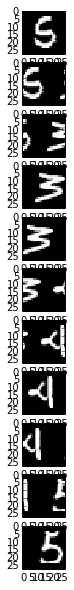

In [5]:
fig = plt.figure()
for i in range(next_seq[0].shape[-1]):
    a = fig.add_subplot(next_seq[0].shape[-1], 1, i+1)
    plt.imshow(next_seq[0][1,:,:,i])

# seq2seq Model

In [6]:
#Start interactive session
gpu_options = tf.GPUOptions(allow_growth = True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=True))


In [7]:
def lenet_over_seq(img_seq, dropout_keep_prob):
    #First convolution
    W_conv_1 = tf.Variable(tf.truncated_normal([5, 5, 1, 20], stddev=0.1), name='W_conv_1')
    b_conv_1 = tf.Variable(tf.constant(0.1, shape=[20]), name='b_conv_1')
    conv1_out = [tf.nn.relu(tf.nn.conv2d(x_in, W_conv_1, strides=[1, 1, 1, 1], padding='SAME') + b_conv_1) for x_in in img_seq]
    h_pool1 = [tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') for h_conv1 in conv1_out]

    #Second convolution
    W_conv_2 = tf.Variable(tf.truncated_normal([5, 5, 20, 50], stddev=0.1), name='W_conv_2')
    b_conv_2 = tf.Variable(tf.constant(0.1, shape=[50]), name='b_conv_2')
    conv2_out = [tf.nn.relu(tf.nn.conv2d(x_in, W_conv_2, strides=[1, 1, 1, 1], padding='SAME') + b_conv_2) for x_in in h_pool1]
    h_pool2 = [tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') for h_conv2 in conv2_out]

    #First dense layer
    h_pool2_flat = [tf.reshape(hp, [-1, 7*7*50]) for hp in h_pool2]
    
    W_dense_1 = tf.Variable(tf.truncated_normal([7*7*50, 500], stddev=0.1), name='W_dense_1')
    b_dense_1 = tf.Variable(tf.constant(0.1, shape=[500]), name='b_dense_1')
    dense_output_1 = [tf.nn.relu(tf.matmul(x_in, W_dense_1) + b_dense_1) for x_in in h_pool2_flat]
    
    #Dropout over 
    h_fc1_drop = [tf.nn.dropout(h_fc1, dropout_keep_prob) for h_fc1 in dense_output_1]

    #Second dense layer
    W_dense_2 = tf.Variable(tf.truncated_normal([500, 11], stddev=0.1), name='W_dense_2')
    b_dense_2 = tf.Variable(tf.constant(0.1, shape=[11]), name='b_dense_2')
    dense_output_2 = [tf.nn.relu(tf.matmul(x_in, W_dense_2) + b_dense_2) for x_in in h_fc1_drop]
    
    return dense_output_2

In [8]:
def variable_summaries(var, name):
    """Attach a lot of summaries to a Tensor."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.scalar_summary('mean/'   + name, mean)
        tf.scalar_summary('sttdev/' + name, tf.sqrt(tf.reduce_mean(tf.square(var - mean))))
        tf.scalar_summary('max/'    + name, tf.reduce_max(var))
        tf.scalar_summary('min/'    + name, tf.reduce_min(var))
        tf.histogram_summary(name, var)


In [9]:
seq_input_len = 11
seq_length = 4

vocab_size = len(char_list) + 3
dim_lstm = 256

#Placeholders
# Input images
with tf.name_scope('inputs') as scope:
    enc_inp = [tf.placeholder(tf.float32, shape=(None,28,28), name="inp%i" % t) for t in range(seq_input_len)]##Change to input images
    enc_inp_reshape = [tf.reshape(img,[-1,28,28,1]) for img in enc_inp]

    word_lens = tf.placeholder(tf.int32, shape=(None), name='word_lens')
    
    # Vectors of dummys variables
    dec_inp = [tf.placeholder(tf.float32, shape=(None,vocab_size), name="labels%i" % t) for t in range(seq_length+1)] # Change to vector of dummies

    weights = [tf.placeholder(tf.float32, shape=(None,), name="weights%i" % t) for t in range(seq_length+1)]
    targets = [tf.placeholder(tf.int32, shape=(None,), name="targets%i" % t) for t in range(seq_length+1)]

    keep_prob = tf.placeholder(tf.float32)



###Model

##Encoder
with tf.name_scope('encoder') as scope:
    #Transform images to input to the LSTM
    input_encoder = lenet_over_seq(enc_inp_reshape, keep_prob)
    variable_summaries(input_encoder, 'input_encoder')

    # LSTM
    '''
    cell_enc = tf.nn.rnn_cell.LSTMCell(dim_lstm,
                                       initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=113),
                                       state_is_tuple=False)
    cell_enc = tf.nn.rnn_cell.DropoutWrapper(cell_enc, output_keep_prob=keep_prob)
    enc_outputs, enc_state = tf.nn.rnn(cell_enc, input_encoder, dtype=tf.float32)
    variable_summaries(enc_outputs, 'enc_outputs')
    '''
    cell_fw = tf.nn.rnn_cell.LSTMCell(dim_lstm,
              initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=123),
                                       state_is_tuple=False)
    cell_bw = tf.nn.rnn_cell.LSTMCell(dim_lstm,
              initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=113),
                                       state_is_tuple=False)
    (enc_outputs, enc_state, _) = tf.nn.bidirectional_rnn(
              cell_fw, cell_bw, input_encoder, dtype=tf.float32,
              sequence_length=word_lens)    
    variable_summaries(enc_outputs, 'enc_outputs')
    print('enc_state',enc_state)
    
    
    #Attention states
    top_states = [tf.reshape(e, [-1, 1, cell_fw.output_size*2]) for e in enc_outputs]
    attention_states = tf.concat(1, top_states)


##Decoder
with tf.name_scope('decoder') as scope:
    W_decoder = tf.Variable(tf.truncated_normal([dim_lstm, vocab_size], stddev=0.1), name='W_decoder')
    variable_summaries(W_decoder, 'W_decoder')
    
    b_decoder = tf.Variable(tf.constant(0.1, shape=[vocab_size]), name='b_decoder')
    variable_summaries(b_decoder, 'b_decoder')

    
    cell_dec = tf.nn.rnn_cell.LSTMCell(dim_lstm,
                                       initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=113),
                                       state_is_tuple=False)
    cell_dec = tf.nn.rnn_cell.DropoutWrapper(cell_dec, output_keep_prob=keep_prob)
    
    
    def loop_function(prev, _):
        # The next input are a softmax of the previous input
        relu_prev = tf.nn.relu(tf.matmul(prev, W_decoder) + b_decoder)
        return tf.nn.softmax(relu_prev)    
    
    def decoder(feed_previous_bool):
        loop_f = None if feed_previous_bool else loop_function
        reuse = None if feed_previous_bool else True
        with tf.variable_scope(
            tf.get_variable_scope(), reuse=reuse) as scope:
            dec_outputs, _ = tf.nn.seq2seq.attention_decoder(dec_inp, enc_state, attention_states, cell_dec,
                                                     loop_function=loop_f)
        return dec_outputs

    # If feed_previous = True --> TEST: use the previous predicted output for the next output
    # If feed_previous = False -->  TRAIN: use the real previous output to predict the next output
    feed_previous = tf.placeholder(tf.bool)
    dec_outputs = tf.cond(feed_previous, lambda: decoder(True), lambda: decoder(False))    
    print('dec_outputs',dec_outputs)
    
    
    
with tf.name_scope('outputs') as scope:
    dense_outputs = [tf.nn.relu(tf.matmul(dec_o, W_decoder) + b_decoder) for dec_o in dec_outputs]
    variable_summaries(dense_outputs, 'dense_outputs')
    print(dense_outputs)
    #Prediction probs
    output = tf.concat(1, [tf.expand_dims(tf.nn.softmax(t),1) for t in dense_outputs])
    print(output)


#Loss
with tf.name_scope('loss') as scope:
    loss = tf.nn.seq2seq.sequence_loss(dense_outputs, targets, weights, name='seq2seq')
    loss_summary = tf.scalar_summary("loss", loss)


#Trainer
with tf.name_scope('trainer') as scope:
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    #optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-08)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)

enc_state Output("encoder/BiRNN/FW/FW/cond_10/Merge_1:0", shape=(?, 512), dtype=float32)
dec_outputs [<tf.Output 'decoder/cond/Merge:0' shape=(?, 256) dtype=float32>, <tf.Output 'decoder/cond/Merge_1:0' shape=(?, 256) dtype=float32>, <tf.Output 'decoder/cond/Merge_2:0' shape=(?, 256) dtype=float32>, <tf.Output 'decoder/cond/Merge_3:0' shape=(?, 256) dtype=float32>, <tf.Output 'decoder/cond/Merge_4:0' shape=(?, 256) dtype=float32>]
[<tf.Output 'outputs/Relu:0' shape=(?, 13) dtype=float32>, <tf.Output 'outputs/Relu_1:0' shape=(?, 13) dtype=float32>, <tf.Output 'outputs/Relu_2:0' shape=(?, 13) dtype=float32>, <tf.Output 'outputs/Relu_3:0' shape=(?, 13) dtype=float32>, <tf.Output 'outputs/Relu_4:0' shape=(?, 13) dtype=float32>]
Output("outputs/concat:0", shape=(?, 5, 13), dtype=float32)


In [10]:
# Merge all the summaries and write them out to /tmp/mnist_logs

summaries_dir = '/tmp/tensorboard/seq2seq_01/run6_1'
with tf.name_scope('summaries') as scope:
    merged = tf.merge_all_summaries()
    train_writer = tf.train.SummaryWriter(summaries_dir + '/train', sess.graph)
    test_writer = tf.train.SummaryWriter(summaries_dir + '/test')

    tf.add_to_collection('merged', merged)

In [11]:
tf.global_variables_initializer().run()
print('vars initialized')

vars initialized


In [12]:
def decode_text(text_array):
    '''
    Decode the target from numbers to words
    '''
    text=[]
    ind_eol=False
    for c in text_array:
        if ind_eol==False:
            text += [str(c)]
        if c==12:
            ind_eol=True
    return '-'.join(text)
print(decode_text(np.array([2, 1, 12, 11], dtype=np.uint8))) #Sandra


2-1-12


In [13]:
def decode_response(response_array):
    response_text = []
    for i in range(response_array.shape[0]):
        response_dec = [np.argmax(r) for r in response_array[i,:,:]]
        #response_text += [''.join([decode_dict[r] for r in response_dec])]
        response_text += [response_dec]
    return response_text

In [14]:
def train_batch(n_epochs, batch_size, lr=0.001, size_word=1):
    step_summary = 0
    for epoch in range(n_epochs):
        loss_cumm = []
        seq = seq_generator(X=mnist.train.images, y=mnist.train.labels, batch_size=batch_size,
                            size_word=size_word, size=seq_length, x_slides=10)
        for s in seq:
            encoder_input = s[0]
            s_len = s[1]
            decoder_input = s[2]
            W = s[3]
            T = s[4]
            # Dimshuffle to seq_len * batch_size
            W = np.array(W).T
            T = np.array(T).T

            feed_dict = {learning_rate: lr, feed_previous: False, keep_prob: 0.5, word_lens: s_len} # False feed_previous in the trainig process.
            feed_dict.update({enc_inp[t]: encoder_input[:,:,:,t] for t in range(seq_input_len)})
            feed_dict.update({dec_inp[t]: decoder_input[:,t,:] for t in range(seq_length+1)})
            feed_dict.update({weights[t]: W[t] for t in range(seq_length+1)})
            feed_dict.update({targets[t]: T[t] for t in range(seq_length+1)})

            _, loss_t = sess.run([train_op, loss], feed_dict)
            loss_cumm += [loss_t]
            
        # Sumaries train    
        summary_str= sess.run(merged, feed_dict)
        train_writer.add_summary(summary_str, step_summary)
        
        #Test
        loss_cumm_tst = []
        correct = 0
        num_cases = 0
        seq_tst = seq_generator(X=mnist.test.images, y=mnist.test.labels, batch_size=batch_size, size_word=size_word, size=seq_length)
        for s_tst in seq_tst:
            encoder_input_tst = s_tst[0]
            s_len_tst = s_tst[1]
            decoder_input_tst = s_tst[2]
            W_tst = s_tst[3]
            T_tst = s_tst[4]
              # Dimshuffle to seq_len * batch_size
            W_tst = np.array(W_tst).T
            T_tst = np.array(T_tst).T

            feed_dict_tst = {feed_previous: True, keep_prob: 1, word_lens: s_len_tst} # True feed_previous in the test process.
            feed_dict_tst.update({enc_inp[t]: encoder_input_tst[:,:,:,t] for t in range(seq_input_len)})
            feed_dict_tst.update({dec_inp[t]: decoder_input_tst[:,t,:] for t in range(seq_length+1)})
            feed_dict_tst.update({weights[t]: W_tst[t] for t in range(seq_length+1)})
            feed_dict_tst.update({targets[t]: T_tst[t] for t in range(seq_length+1)})

            loss_tst, out_tst = sess.run([loss, output], feed_dict_tst)
            loss_cumm_tst += [loss_tst]
            
            response_predict_text = decode_response(out_tst)
            for resp in range(len(out_tst)):
                num_cases += 1
                if decode_text(s_tst[4][resp]) == decode_text(response_predict_text[resp]):
                    correct += 1

        # Sumaries test    
        summary_str = sess.run(merged, feed_dict_tst)
        test_writer.add_summary(summary_str, step_summary)
        step_summary += 1
           
        print('Epoch: ',epoch, '- Loss trn: ', np.mean(loss_cumm), ' - Loss tst: ', np.mean(loss_cumm_tst))
        print('Correct: ', correct, ' - pct correct: ', float(correct)/float(num_cases))
        
        # Print some results
        '''
        correct = 0
        response_predict_text = decode_response(out_tst)
        for resp in range(len(out_tst)):
            #print(decode_text(s_tst[4][resp]), ' vs ', decode_text(response_predict_text[resp]))
            if decode_text(s[4][resp]) == decode_text(response_predict_text[resp]):
                correct += 1
        print('pct correct: ', correct, float(correct)/(resp+1))
        '''           
    return loss_t, out_tst

In [15]:
loss_t, out_tst, real_text = train_batch(15, 256, lr=0.03, size_word=1)

Epoch:  0 - Loss trn:  1.42536  - Loss tst:  0.99614
Correct:  22036  - pct correct:  0.430390625
Epoch:  1 - Loss trn:  0.765314  - Loss tst:  0.382447
Correct:  39981  - pct correct:  0.78087890625
Epoch:  2 - Loss trn:  0.389601  - Loss tst:  0.211067
Correct:  45174  - pct correct:  0.8823046875
Epoch:  3 - Loss trn:  0.256948  - Loss tst:  0.145337
Correct:  46875  - pct correct:  0.91552734375
Epoch:  4 - Loss trn:  0.196556  - Loss tst:  0.113187
Correct:  47712  - pct correct:  0.931875
Epoch:  5 - Loss trn:  0.159892  - Loss tst:  0.0965839
Correct:  48234  - pct correct:  0.9420703125
Epoch:  6 - Loss trn:  0.140841  - Loss tst:  0.0839459
Correct:  48600  - pct correct:  0.94921875
Epoch:  7 - Loss trn:  0.127243  - Loss tst:  0.0747517
Correct:  48898  - pct correct:  0.9550390625
Epoch:  8 - Loss trn:  0.111886  - Loss tst:  0.0684258
Correct:  49088  - pct correct:  0.95875
Epoch:  9 - Loss trn:  0.102721  - Loss tst:  0.0631743
Correct:  49222  - pct correct:  0.96136718

ValueError: need more than 2 values to unpack

In [ ]:
loss_t, out_tst = train_batch(6, 256, lr=0.03, size_word=2)

In [ ]:
loss_t, out_tst = train_batch(6, 256, lr=0.03, size_word=3)

In [ ]:
loss_t, out_tst = train_batch(30, 256, lr=0.03, size_word=4)

In [55]:
seq = seq_generator(X=mnist.test.images, y=mnist.test.labels, batch_size=256,
                    size_word=4, size=seq_length)
s = next(seq)        
encoder_input = s[0]
s_len = s[1]
decoder_input = s[2]
W = s[3]
T = s[4]
# Dimshuffle to seq_len * batch_size
W = np.array(W).T
T = np.array(T).T


In [56]:
#Recode the decoder input
print(decoder_input.shape)
print(decoder_input[0])
decoder_input_noinfo = np.zeros_like(decoder_input)
for i, di in enumerate(decoder_input_noinfo):
    for j, dj in enumerate(di):
        decoder_input_noinfo[i,j,-2]=1
print(decoder_input_noinfo[0])


(256, 5, 13)
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]]


In [57]:

feed_dict = { feed_previous: True, keep_prob: 1, word_lens: s_len} # False feed_previous in the trainig process.
feed_dict.update({enc_inp[t]: encoder_input[:,:,:,t] for t in range(seq_input_len)})
feed_dict.update({dec_inp[t]: decoder_input_noinfo[:,t,:] for t in range(seq_length+1)})
feed_dict.update({weights[t]: W[t] for t in range(seq_length+1)})
feed_dict.update({targets[t]: T[t] for t in range(seq_length+1)})

out_tst, outs, l = sess.run([output, dense_outputs, loss], feed_dict)
print(outs[0].shape)
print(l)

(256, 13)
0.0349198


In [61]:
# Print some results
correct=0
response_predict_text = decode_response(out_tst)
#real_text = [''.join([decode_dict[r] for r in rr]) for rr in T.T]
for resp in range(256):
    print(decode_text(s[4][resp]), ' vs ', decode_text(response_predict_text[resp]))
    if decode_text(s[4][resp]) == decode_text(response_predict_text[resp]):
        correct += 1
print('pct correct: ', correct, float(correct)/(resp+1))



1-9-9-4-12  vs  1-9-9-4-12
0-2-12  vs  0-2-12
6-6-5-3-12  vs  6-6-5-3-12
7-8-12  vs  7-8-12
3-12  vs  5-12
9-12  vs  9-12
9-1-12  vs  9-1-12
7-5-3-12  vs  7-5-3-12
0-1-8-12  vs  0-1-8-12
4-2-7-3-12  vs  4-2-7-3-12
3-4-2-5-12  vs  3-4-2-5-12
7-2-3-5-12  vs  7-2-3-5-12
2-12  vs  2-12
6-0-9-12  vs  6-0-9-12
1-4-6-6-12  vs  1-4-6-6-12
2-8-12  vs  2-8-12
2-3-9-1-12  vs  2-3-9-1-12
5-4-12  vs  5-4-12
2-3-9-7-12  vs  2-3-9-7-12
3-12  vs  3-12
3-4-3-12  vs  3-4-3-12
5-5-7-12  vs  5-5-7-12
2-8-0-2-12  vs  2-8-0-2-12
1-0-3-12  vs  1-0-3-12
5-4-4-3-12  vs  5-4-4-3-12
5-12  vs  5-12
2-6-3-12  vs  2-6-3-12
4-3-1-8-12  vs  4-3-1-8-12
7-9-1-1-12  vs  7-9-1-1-12
1-3-9-7-12  vs  1-3-9-7-12
7-2-12  vs  7-2-12
2-6-8-7-12  vs  2-6-8-7-12
8-12  vs  8-12
9-1-6-12  vs  9-1-6-12
0-1-6-5-12  vs  0-1-6-5-12
7-1-3-12  vs  7-1-3-12
2-1-9-0-12  vs  2-1-9-0-12
0-4-4-1-12  vs  0-4-4-1-12
8-12  vs  8-12
0-6-12  vs  0-6-12
5-4-3-12  vs  5-4-3-12
3-12  vs  3-12
0-9-8-7-12  vs  0-9-8-1-12
3-4-6-12  vs  3-4-6-12
1-7-6-12

[ 3 12 10 10 10]
[5, 12, 12, 12, 12]


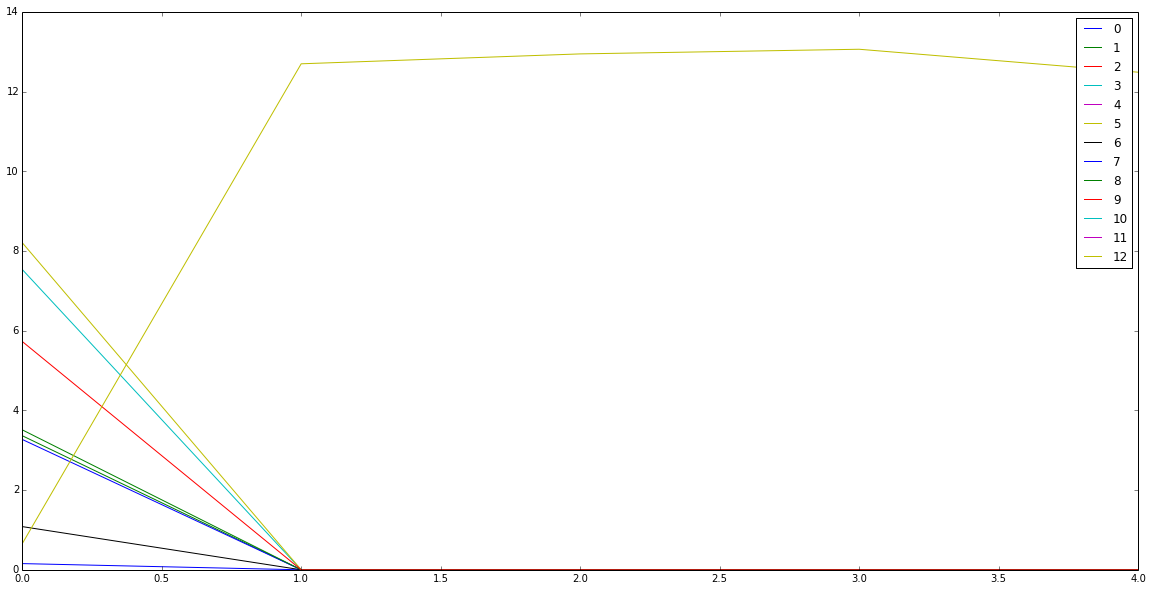

In [59]:
#Plot probabilities for one case
def plot_graph(logits3d, i):
    #Graph
    print(s[4][i])
    response_dec = [np.argmax(r) for r in logits3d[:,i,:]]
    response_text = [''.join([decode_dict[r] for r in response_dec])]
    print(response_dec)
    plt.figure(figsize=(20,10))
    legend =[]
    for position in range(logits3d.shape[2]):
        plt.plot(range(logits3d.shape[0]), logits3d[:,i,position])
        legend += [position]
    plt.legend(legend)
    plt.show()

plot_graph(np.array(outs), 4)